In [5]:
# TIME : 2023/12/19 15:08

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# -------------------- 自定义函数 begin -------------------- #
# Try 2 begin -------------------------------------------------- #
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8, count=-1)
    return data[16:].reshape(-1, 28*28) / 255.0


def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8, count=-1)
    return data[8:]


# 定义划分函数的时候加上随机种子，保证划分结果的可重复性
def split_dataset(x, y, test_size=0.2, random_state=None):
    # 获取数据集的长度
    data_size = len(x)

    # 根据比例计算验证集的大小
    val_size = int(test_size * data_size)

    # 设置随机种子
    if random_state is not None:
        np.random.seed(random_state)

    # 随机打乱数据集
    indices = np.random.permutation(data_size)

    # 划分数据集
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    # 获取划分后的数据
    x_train, x_val = x[train_indices], x[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    return x_train, x_val, y_train, y_val


# 初始化权重
def initialize_weights(input_variables_size, weights_init_val=None):
    if weights_init_val is not None:
        weight_i = np.ones(input_variables_size) * weights_init_val
        weight_0 = np.ones(1) * weights_init_val
    else:
        weight_i = np.random.rand(input_variables_size)
        weight_0 = np.random.rand(1)
    return weight_i, weight_0


def adaline_train(x, y, weights_init_val, learning_rate = 0.01, epochs = 50, stopping_threshold = 0.01):
    input_variables_size = len(x[0])
    weight_i, weight_0 = initialize_weights(input_variables_size, weights_init_val)

    # train_errors = np.zeros(epochs)  # 预分配内存
    # 应该这样写，上面的写法会影响后面的作图过程
    train_errors = []

    for epoch in range(epochs):
        train_error = 0
        for i in range(x.shape[0]):
            xi = x[i, :]
            target = y[i]

            # dot_product = sum(xi_j * weight_i_j for xi_j, weight_i_j in zip(xi, weight_i))
            # 运行时间太长了，我猜测是此处循环的问题，改用以下

            dot_product = np.sum(xi * weight_i)
            prediction = dot_product + weight_0
            update = learning_rate * (target - prediction)
            weight_i = weight_i + update * xi
            weight_0 = weight_0 + update
            train_error = train_error + (target - prediction)**2  # 使用平方损失函数

        train_mean_squared_error = train_error / x.shape[0]
        # train_errors[epoch] = train_mean_squared_error
        train_errors.append(train_mean_squared_error)

        if train_mean_squared_error < stopping_threshold:
            break

    # 返回最终权重
    final_weight_i = weight_i
    final_weight_0 = weight_0

    return train_errors, final_weight_i, final_weight_0


# 使用训练好的参数进行预测
def predict_with_parameters(x, weight_i, weight_0):
    predictions = np.sign(np.dot(x, weight_i) + weight_0)
    return predictions


# 计算错误率
def calculate_error_rate(predictions, actual_labels):
    incorrect_samples = np.sum(predictions != actual_labels)
    correct_samples = np.sum(predictions == actual_labels)

    error_rate = incorrect_samples / len(actual_labels)
    correct_rate = correct_samples / len(actual_labels)
    
    return error_rate, correct_rate


# 计算混淆矩阵
def calculate_confusion_matrix(verify, predict):
    true_positive = np.sum((verify == 1) & (predict == 1))
    false_positive = np.sum((verify == -1) & (predict == 1))
    true_negative = np.sum((verify == -1) & (predict == -1))
    false_negative = np.sum((verify == 1) & (predict == -1))

    return np.array([[true_negative, false_positive], [false_negative, true_positive]])


# 绘制混淆矩阵
def plot_confusion_matrix(confusion_matrix, title):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    # plt.colorbar()
    # 这个 colorbar 可以在图像旁边显示颜色对应的数值
    classes = ['other', '6']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('true label')
    plt.ylabel('predict label')

    # 这段代码是在绘制的矩阵中添加数字标签
    for i in range(len(classes)):
        for j in range(len(classes)):
            # 根据颜色深浅选择标签颜色
            # text_color = 'white' if confusion_matrix[i, j] > confusion_matrix.max() / 2 else 'black'
            text_color = 'white' if confusion_matrix[i, j] > confusion_matrix.mean() else 'black'
            plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color=text_color)

# -------------------- 自定义函数 end  -------------------- #

In [7]:
train_images_file = 'train_data/train-images.idx3-ubyte'
train_labels_file = 'train_data/train-labels.idx1-ubyte'

train_images_array = load_mnist_images(train_images_file)
train_labels_array = load_mnist_labels(train_labels_file)

train_label_binary = np.where(train_labels_array == 6, 1, -1)

# 划分训练集和验证集
# 定义划分函数的时候加上随机种子，保证划分结果的可重复性
train_feature, verify_feature, train_label, verify_label = \
    split_dataset(train_images_array, train_label_binary, test_size=0.2, random_state=42)

### ---2023.12.26---
### 注意这样写是错误的，要用已经`划分过的数据集`
``` python
errors1, final_weight_i_1, final_weight_0_1 = \
    adaline_train(train_images_array, train_label, weights_init_val=0, learning_rate=0.01, stopping_threshold=0.018)
```
### 这里的 train_images_array 要换成 train_feature

In [8]:
# 实验1: 不同初始权重
errors1, final_weight_i_1, final_weight_0_1 = \
    adaline_train(train_feature, train_label, weights_init_val=0, learning_rate=0.01, stopping_threshold=0.18)
errors2, final_weight_i_2, final_weight_0_2 = \
    adaline_train(train_feature, train_label, weights_init_val=1, learning_rate=0.01, stopping_threshold=0.18)

# 实验2: 不同训练速率
errors3, final_weight_i_3, final_weight_0_3 = \
    adaline_train(train_feature, train_label, weights_init_val=1, learning_rate=0.001, stopping_threshold=0.18)
errors4, final_weight_i_4, final_weight_0_4 = \
    adaline_train(train_feature, train_label, weights_init_val=1, learning_rate=0.015, stopping_threshold=0.18)

Text(0.5, 1.0, 'Experiment 2: Zero Initial Weights - Learning Rate: 0.015')

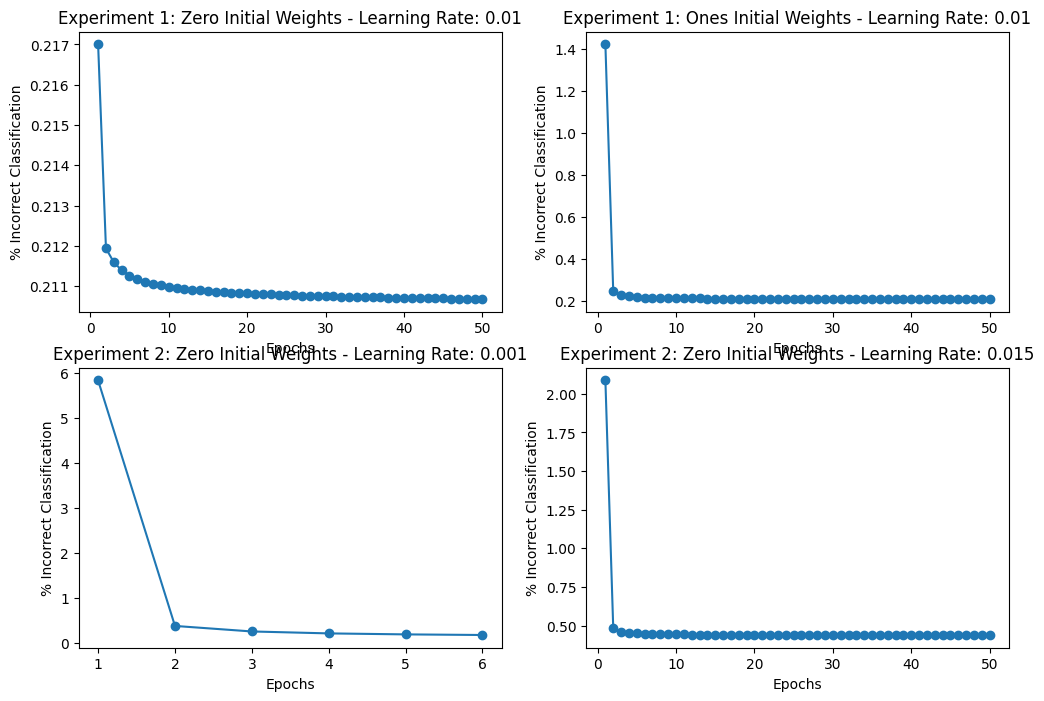

In [9]:
# 绘制训练集的错误率随时间变化的图表
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(range(1, len(errors1) + 1), errors1, marker='o')
plt.xlabel('Epochs')
plt.ylabel('% Incorrect Classification')
plt.title('Experiment 1: Zero Initial Weights - Learning Rate: 0.01')

plt.subplot(2, 2, 2)
plt.plot(range(1, len(errors2) + 1), errors2, marker='o')
plt.xlabel('Epochs')
plt.ylabel('% Incorrect Classification')
plt.title('Experiment 1: Ones Initial Weights - Learning Rate: 0.01')

plt.subplot(2, 2, 3)
plt.plot(range(1, len(errors3) + 1), errors3, marker='o')
plt.xlabel('Epochs')
plt.ylabel('% Incorrect Classification')
plt.title('Experiment 2: Zero Initial Weights - Learning Rate: 0.001')

plt.subplot(2, 2, 4)
plt.plot(range(1, len(errors4) + 1), errors4, marker='o')
plt.xlabel('Epochs')
plt.ylabel('% Incorrect Classification')
plt.title('Experiment 2: Zero Initial Weights - Learning Rate: 0.015')

In [10]:
# -------------------- 为测试集绘制相应的图表 begin -------------------- #
# 在测试集上验证不同实验的错误率
predict_label_1 = predict_with_parameters(verify_feature, final_weight_i_1, final_weight_0_1)
predict_label_2 = predict_with_parameters(verify_feature, final_weight_i_2, final_weight_0_2)
predict_label_3 = predict_with_parameters(verify_feature, final_weight_i_3, final_weight_0_3)
predict_label_4 = predict_with_parameters(verify_feature, final_weight_i_4, final_weight_0_4)

error_rate_1, correct_rate_1 = calculate_error_rate(predict_label_1, verify_label)
error_rate_2, correct_rate_2 = calculate_error_rate(predict_label_2, verify_label)
error_rate_3, correct_rate_3 = calculate_error_rate(predict_label_3, verify_label)
error_rate_4, correct_rate_4 = calculate_error_rate(predict_label_4, verify_label)

print("Experiment 1 Error Rate (Zero Initial Weights):", error_rate_1 * 100, "%")
print("Experiment 1 Correct Rate (Zero Initial Weights):", correct_rate_1 * 100, "%")

print("Experiment 1 Error Rate (Ones Initial Weights):", error_rate_2 * 100, "%")
print("Experiment 1 Correct Rate (Ones Initial Weights):", correct_rate_2 * 100, "%")

print("Experiment 2 Error Rate (Learning Rate: 0.001):", error_rate_3 * 100, "%")
print("Experiment 2 Correct Rate (Learning Rate: 0.001):", correct_rate_3 * 100, "%")

print("Experiment 2 Error Rate (Learning Rate: 0.015):", error_rate_4 * 100, "%")
print("Experiment 2 Correct Rate (Learning Rate: 0.015):", correct_rate_4 * 100, "%")

Experiment 1 Error Rate (Zero Initial Weights): 2.9749999999999996 %
Experiment 1 Correct Rate (Zero Initial Weights): 97.02499999999999 %
Experiment 1 Error Rate (Ones Initial Weights): 2.966666666666667 %
Experiment 1 Correct Rate (Ones Initial Weights): 97.03333333333333 %
Experiment 2 Error Rate (Learning Rate: 0.001): 3.166666666666667 %
Experiment 2 Correct Rate (Learning Rate: 0.001): 96.83333333333334 %
Experiment 2 Error Rate (Learning Rate: 0.015): 3.783333333333333 %
Experiment 2 Correct Rate (Learning Rate: 0.015): 96.21666666666667 %


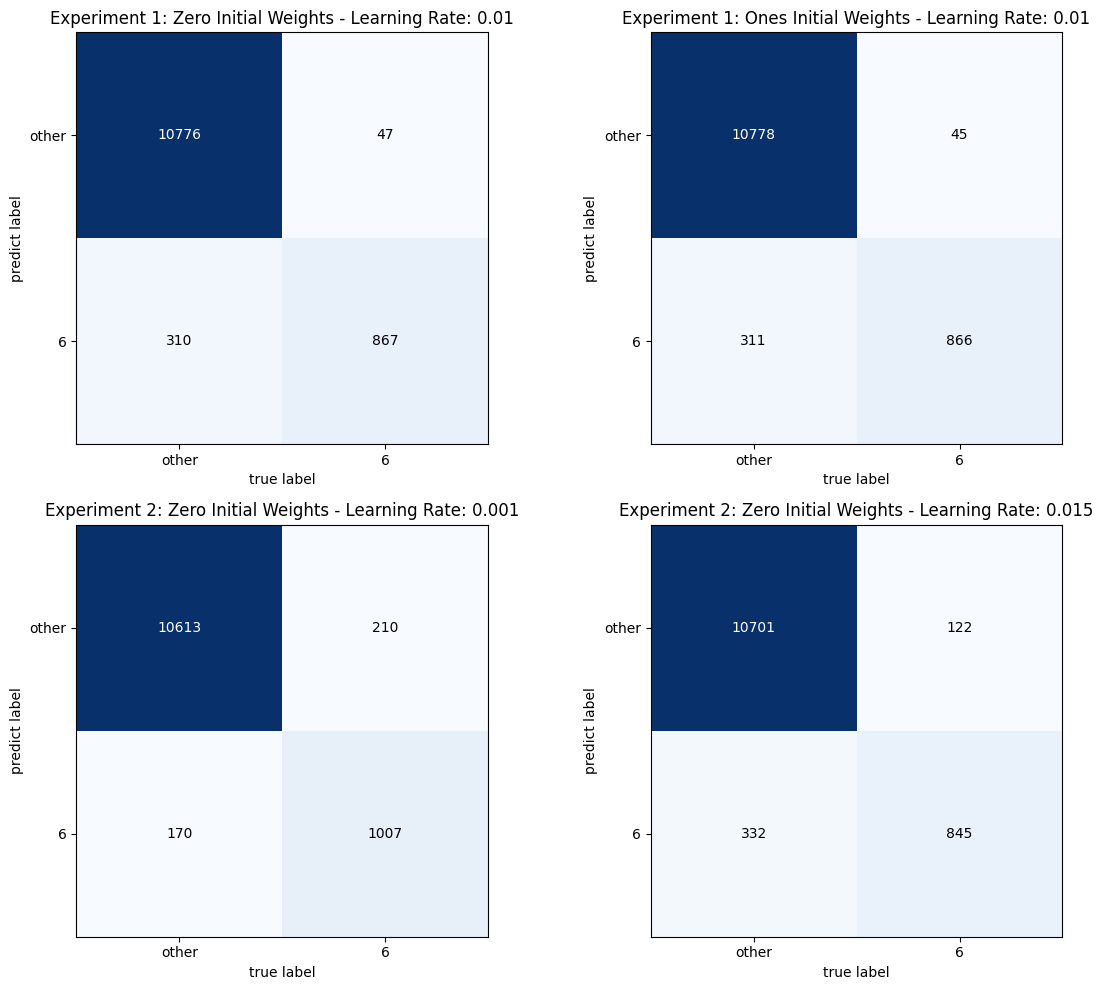

In [12]:
# -------------------- 为测试集绘制混淆矩阵 begin -------------------- #
# 计算每个实验的混淆矩阵
confusion_matrix_1 = calculate_confusion_matrix(verify_label, predict_label_1)
confusion_matrix_2 = calculate_confusion_matrix(verify_label, predict_label_2)
confusion_matrix_3 = calculate_confusion_matrix(verify_label, predict_label_3)
confusion_matrix_4 = calculate_confusion_matrix(verify_label, predict_label_4)

# Plot confusion matrix for each experiment
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix_1, 'Experiment 1: Zero Initial Weights - Learning Rate: 0.01')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix_2, 'Experiment 1: Ones Initial Weights - Learning Rate: 0.01')

plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix_3, 'Experiment 2: Zero Initial Weights - Learning Rate: 0.001')

plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix_4, 'Experiment 2: Zero Initial Weights - Learning Rate: 0.015')

plt.tight_layout()
plt.show()
# -------------------- 为测试集绘制混淆矩阵 end   -------------------- #

*以下是调用库函数的测试代码*

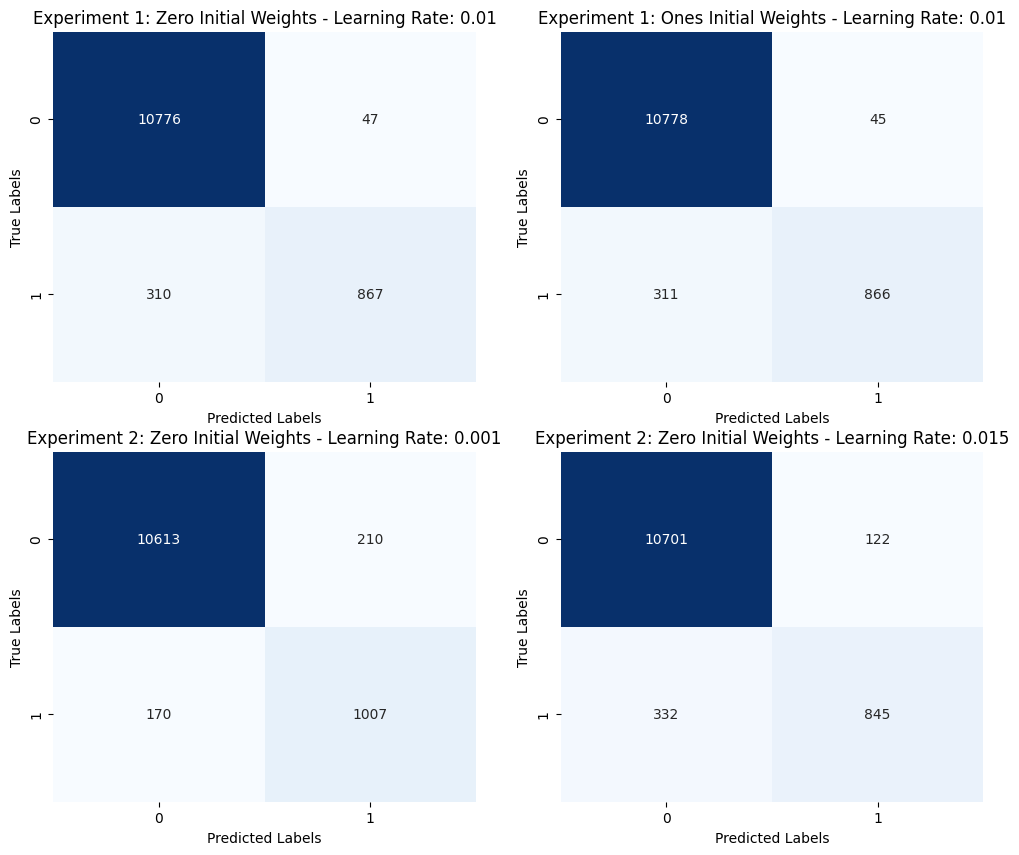

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
cm = confusion_matrix(verify_label, predict_label_1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Experiment 1: Zero Initial Weights - Learning Rate: 0.01')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(2, 2, 2)
cm = confusion_matrix(verify_label, predict_label_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Experiment 1: Ones Initial Weights - Learning Rate: 0.01')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(2, 2, 3)
cm = confusion_matrix(verify_label, predict_label_3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Experiment 2: Zero Initial Weights - Learning Rate: 0.001')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.subplot(2, 2, 4)
cm = confusion_matrix(verify_label, predict_label_4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Experiment 2: Zero Initial Weights - Learning Rate: 0.015')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()